# Long-Short Term Memory Recurrent Neural Network (LSTM RNN) for predicting Gold prices
## Programmed by: Laramie Dunlap 10/17/2022


With this notebook, I will demonstrate some cool functionalities Python provides for building out deep learning models and how they can be used to inform trading decisions.

### Step 1: Setting up a simple data pipeline

I'm going to use Alpaca's free trade api to get our data. For this example, I'm going to use GLD as the target we're trying to predict, and then use TLT, HYG, USO, and SPY as features. In trading terms, we're going to try and predict Gold movement based on 4 correlated markets: T-bonds, junk bonds, oil, and the S&P 500. 

It's important to start out a machine learning project's data pipeline in a way that allows data scientists and feature engineers to easily manipulate and test different variables and lookback periods. After the initial imports, I'll write a couple simple methods to help ensure we do just that.

In [1]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

# Import Alpaca functions and environmental variables
from alpaca_trade_api.rest import REST, TimeFrame
from dotenv import load_dotenv

load_dotenv()

# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [2]:
import datetime
from datetime import date, timedelta
import re
# Define functions I use to get Alpaca Trade API data

def calc_start_date(years_ago: int) -> str:
    """Calculates the date 'x' years ago and returns a string that can be used with the tradeapi"""
    to_day=str(date.today())
    match = re.match(r'(\d\d\d\d)-(\d\d)-(\d\d)', to_day)
    _yrsago= int(match.group(1))-years_ago
    _yrsago = str(_yrsago)+'-'+match.group(2)+'-'+match.group(3)
    return _yrsago

def _end():
    """Returns the end time for our get_data method. Alpaca's free version does not permit querying data from the past 15 minutes"""
    return (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16)).strftime('%Y-%m-%dT%H:%M:%SZ')

def get_data(ticker, start, end, tradeapi) -> pd.DataFrame:
    """Executes the get_bars method from Alpaca Trade API and returns a dataframe"""
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

In [3]:

# Get Data from API into a Pandas dataframe:
spy_df = get_data("SPY", calc_start_date(5), _end(), tradeapi)
spy_df.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2017-10-17 04:00:00+00:00,255.24,255.52,254.9800,255.47,32507646,120555,254.627844
2017-10-18 04:00:00+00:00,255.92,255.95,255.5000,255.72,40936574,121862,255.720138
2017-10-19 04:00:00+00:00,254.83,255.83,254.3500,255.79,61948288,190692,255.297268
2017-10-20 04:00:00+00:00,256.73,257.14,255.7744,257.11,89178367,196614,256.766187
2017-10-23 04:00:00+00:00,257.51,257.51,256.0200,256.11,64001716,196938,256.704266


### So we get a lot of columns for each ticker. 

This may or may not be useful, but if we built our initial data pull function (get_data)  *too narrowly*  (i.e. only getting the close column), it would be difficult to go back and change the process if we decided to investigate tradecount or range, etc. 

One thing we don't need is the timestamp that follows the date in our index column, since these ETFs will always have end of day data recorded at the same time.

Next we're going to write a function to clean up our timestamp index (which will be ignored anyway by the nueral network but added back in later for plotting), and we'll make a function to take in a string of tickers and return their closing values in a dataframe. 

In [4]:
def clean_index(_df: pd.DataFrame) -> list:
    """returns a cleaned up date index column on a dataframe"""
    _index = _df.index.to_list()
    return [i.date() for i in _index]

def get_feature_and_tgt_close(list_f: list, tgt:str, yrsago:int) -> pd.DataFrame:
    """Takes a list of feature tickers, a target ticker, and a lookback period, and returns a dataframe of their closing prices"""
    df = pd.DataFrame()
    
    # add feature ticker closing prices
    for tk in list_f:
        temp_df = get_data(tk, calc_start_date(yrsago), _end(), tradeapi)
        temp_df.index = clean_index(temp_df)
        df[tk] = temp_df['close']
    
    # add target ticker closing prices
    temp_df = get_data(tgt, calc_start_date(yrsago), _end(), tradeapi)
    temp_df.index = clean_index(temp_df)
    df[tgt] = temp_df['close']
    
    # drop records with NaN from the returned dataframe (sometimes the issue dates won't line up, so you want to make sure the data is consistent in length)
    return df.dropna()


In [5]:

user_df = get_feature_and_tgt_close(['TLT', 'HYG', 'SPY'], 'GLD', 5)
user_df.head()

,TLT,HYG,SPY,GLD
2017-10-17,125.92,88.51,255.47,122.13
2017-10-18,125.09,88.60,255.72,121.67
2017-10-19,125.31,88.61,255.79,122.39
2017-10-20,123.98,88.69,257.11,121.61
2017-10-23,124.20,88.59,256.11,121.80


#### Nifty!

Now we've got a nice, flexible pipeline. Our initial data pull is seperated from this specific machine learning application, so we've got some forward compatibaility built in. At this point in the development process, I would move the basic functions (get_data, calc_start_date, clean_index) into a util.py file, as these are the base functions for our Machine Learning suite. The get_feature_and_tgt_close function is a really long method name, but readability == useability. I would move this function into a more specific lstm.py file, depending on how broad or narrow the nature of the program. 

We could also use the df.to_csv() method to save a copy of our data and start building a database this way, then check our database for it first (our models can be cached and reloaded as well)

Alright now to the cool stuff.

### Step 2: Cooking the Data

### Scaling with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. Machine learning models tend to do better with smaller numbers. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

A lot of people like to shape and split their data then scale it -- which is fine when you're working with 2D data. However, We're in the deep end. We have a model that will take `N` weekly windows of `5` days, for `X` different features. That's a **3** dimensional model (at 4 it gets really spicy from a programming standpoint) The shape of your data is the hardest part with neural networks, and often the most abstract and difficult to visualize. 

**KEY POINT**: The preprocessing scalers most data scientists use in python are built for 2D arrays. So either you need to flatten and reshape data structures (a bunch), or just scale the data prior to shaping and splitting into your train-test groups. 

As an aside, you can also create your own 3D scalers. You have to build an inherited class from the one we're importing below -- which would show off some cool python skills but in reality just makes the codebase harder to deal with. 

**ANOTHER KEY POINT**: One of the main reasons people like to split up their data before fitting a scaler is because you *MUST NOT* fit the scaler to all your data, only the training portion. Otherwise, you are letting your model see the shape of the answers to a test... on shapes.

In [6]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# These are some variables we're going to be using a lot in this notebook.
window = 5

df = user_df
feature_cols = df.columns[:-1]
target_col = df.columns[-1]

test_ratio = 0.7
test_range = int(round(len(df)*test_ratio,0))

# Each feature needs its own scaler, so we'll make a dictionary to help keep track of these so we can use them later to inverse transform.
scaler_dict = {c: None for c in df.columns}
for key in scaler_dict.keys():
    scaler_dict[key] = MinMaxScaler()
    _train = np.array(df[key].iloc[0:test_range].values).reshape(-1,1)
    scaler_dict[key].fit(_train)
    df[[key]] = scaler_dict[key].transform(df[[key]])

# Note: Warnings come from a version of sklearn that included the user warnings -- not a big deal to worry about. 
display(df.head())
display(scaler_dict)

c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,TLT,HYG,SPY,GLD
2017-10-17,0.233675,0.991027,0.167361,0.133229
2017-10-18,0.219741,0.995513,0.168648,0.127672
2017-10-19,0.223435,0.996012,0.169008,0.136369
2017-10-20,0.201108,1.000000,0.175802,0.126948
2017-10-23,0.204801,0.995015,0.170655,0.129243


{'TLT': MinMaxScaler(),
 'HYG': MinMaxScaler(),
 'SPY': MinMaxScaler(),
 'GLD': MinMaxScaler()}

### Step 3: Creating the Features `X` and Target `y` Data

The next step towards preparing the data is to create the input features vectors `X` and the target vector `y`. This is standard nomenclature for machine learning variables. We will use a `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_cols`: The columns where the features are located.

* `target_col`: The column where the target is located.

In [12]:
def window_data(df, feature_cols, target_col, window):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    def reshape_arr(_arr: np.array) -> tuple:
        """returns the right shape"""
        features = len(feature_cols)
        size = _arr.shape[0]*_arr.shape[1]
        return _arr.reshape(int((size/(features*window))),features,window)
    
    X = []
    y = []
    for i in range(len(df) - window):
        for c in feature_cols: 
            features = df.iloc[i : (i + window), df.columns.get_loc(c)].values
            X.append(features)
        target = df.iloc[(i + window), df.columns.get_loc(target_col)]
        y.append(target)
    X = reshape_arr(np.array(X))
    y = np.array(y).reshape(len(y),1,1)
    return  X , y

In [13]:
X , y = window_data(df, feature_cols, target_col, window)
print (f"X sample values:\n{X[:2]} \n")
print (f"y sample values:\n{y[:2]}")


X sample values:
[[[0.23367467 0.21974148 0.22343461 0.20110794 0.20480107]
  [0.99102692 0.99551346 0.99601196 1.         0.99501496]
  [0.16736143 0.16864804 0.16900829 0.17580155 0.17065514]]

 [[0.21974148 0.22343461 0.20110794 0.20480107 0.1918751 ]
  [0.99551346 0.99601196 1.         0.99501496 0.99501496]
  [0.16864804 0.16900829 0.17580155 0.17065514 0.17297103]]] 

y sample values:
[[[0.12356565]]

 [[0.12380722]]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing with our `test_ratio` variable.

In [14]:
# We're going to use 70% of the data for training and the remainder for testing. While notebooks are good for exploring and testing data,
# I would set this as a user option in a webapp. Would be very straightforward. 
split = int(test_ratio * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

---

## Step 4: Build and Train the LSTM RNN

Now it's time to design a custom LSTM RNN in Keras and fit (train) it using the training data we've piped in, cleaned, and sliced.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layers. We're also going to utilize a layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [15]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.20`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous of closing `feature` prices to predict the next `target` closing price.

In [18]:
X_train.shape

(877, 3, 5)

In [116]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1],5)
    ))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [117]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [118]:
# Summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 3, 5)              220       
                                                                 
 dropout_16 (Dropout)        (None, 3, 5)              0         
                                                                 
 lstm_18 (LSTM)              (None, 3, 5)              220       
                                                                 
 dropout_17 (Dropout)        (None, 3, 5)              0         
                                                                 
 lstm_19 (LSTM)              (None, 5)                 220       
                                                                 
 dropout_18 (Dropout)        (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [119]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
877/877 [==============================] - 4s 2ms/step - loss: 0.0070
Epoch 2/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 3/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0121
Epoch 4/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0124
Epoch 5/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 6/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0152
Epoch 7/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0158
Epoch 8/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0145
Epoch 9/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0119
Epoch 10/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0102


Now we will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

In [120]:
# Evaluate the model
model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 1ms/step - loss: 0.0340


0.034010518342256546

In [121]:
# Make some predictions
predicted = model.predict(X_test)

In [122]:
# Recover real GLD prices from the scaled versions
predicted_prices = scaler_dict['GLD'].inverse_transform(predicted)
real_prices = scaler_dict['GLD'].inverse_transform(y_test.reshape(-1, 1))

In [123]:
# Create a DataFrame of Real and Predicted values
gld = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
gld.head()

,Real,Predicted
2021-04-21,168.13,162.587692
2021-04-22,167.04,162.624863
2021-04-23,166.40,162.706482
2021-04-26,166.84,162.810638
2021-04-27,166.42,162.836823


<AxesSubplot:>

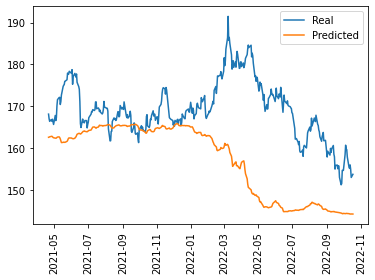

In [124]:
gld.plot(rot=90)

### Interesting results
The model seemed to predict things would get pretty bad well before they did for gold prices. I've included some more code below that can help determine whether or not the model is good at prediciting individual daily movements. 

In [125]:
gld['real_change'] = gld['Real'].shift(-1) - gld['Real']
gld['real_change'] = gld['real_change'].shift() 
gld['pred_change'] = gld['Predicted'].shift(-1) - gld['Predicted']
gld['pred_change'] = gld['pred_change'].shift() 
conditions = [
    (gld['real_change'] > 0) & (gld['pred_change'] > 0), 
    (gld['real_change'] < 0) & (gld['pred_change'] > 0),
    (gld['real_change'] < 0) & (gld['pred_change'] < 0),
    (gld['real_change'] > 0) & (gld['pred_change'] < 0),
]

values = ['true positive', 'false positive', 'true negative', 'false negative']
gld['direction'] = np.select(conditions, values)

In [127]:
gld['direction'].value_counts()

false negative    112
true negative      96
false positive     87
true positive      81
0                   1
Name: direction, dtype: int64

# Conclusion
---
So while it isn't the GREATEST looking model, I can say from testing that this model would perform better using only the price action from GLD itself. All in all, this took about half a day to program from front to back, including all the comments, debugging, and everything else that comes with machine learning. 

If you're building this model BEFORE trying any others, I highly recommend trying random forest and other simpler machine learning models first. While neural networks are definitely great tools for approaching the markets, there are plenty of other options that can be spun up faster with out as much data wrangling (keras is a very picky eater!)

Thank you for following along, hope this was helpful!